# Finding mechanisms of falling consumer interest in big online discussion data


## Marjoriikka Ylisiurua University of Helsinki 24 August 2021 PhD thesis, phase 3:


Research question and its justification.
- clean Suomi24 data
- show time series (both own exploration/final viz) - compare with what Winnie did
1. phase 1: analyse sample dataset (Economic topic level 2) - sent for code review
2. phase 2: several topic 2 levels in one file, separate (plot subplots as necessary)
3. phase 3: full data


In [1]:
# check Python version; 3.8.8 at home
!python -V

import logging
import os

# note how to install on the fly
#!pip install bokeh
#!pip install pycoingecko
#!pip install plotly
#!pip install mplfinance
#!pip install bs4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

# regressions
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

import datetime

from time import time
import csv

#from sklearn.preprocessing import StandardScaler
import warnings

logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
# warnings.filterwarnings('ignore')

"""
init basic global selections like color scheme and image dimensions
"""
sns.set_palette("colorblind")
# for bar/line/boxplot charts, scatter plots, and heatmaps
histpalette = "light:m_r"
barpalette = sns.color_palette("Blues", n_colors=12, as_cmap=True)
heatpalette = sns.color_palette("icefire")
#cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
cmap = sns.cubehelix_palette(rot=-.2)

# set image dimensions
image_dims = (15, 7) 
image_dims_large = (15, 15)

# set chosen training set size
trainingSetSize=0.8
testSize = 0.2

Python 3.8.8


# init

In [2]:
"""
# DATA EXTRACTION - reading txt files in as csv
# if starting from scratch, create new file
"""

## as per Matti's suggestion, open files already here
# it works, if the kiikku is not used elsewhere

sampleData = False  # kiikku: analysing toy sample pieni.txt (True) or actual data set (False)
partialData = False #kiikku: tarkastele kokonaisesta fileestä vain muutamia sampleTXT/  alakeskusteluja (True) or whole data set (False)
existingCSV = True  # kiikku: using existing csv (True) or creating new big file from scratch (False)

if sampleData:
    searchDirectorySample = ("/Users/mry/SFI/")
    outcomeSampleDir = ("/Users/mry/SFI/")
    openFileName = "/Users/mry/SFI/iso.txt"  ## original csv file with lemmatized texts
    saveFileName = "/Users/mry/SFI/iso.csv" ## save file
    shortFileName = "esimerkkidata Iso"

    print("toy sample")
    print("open sample: "+openFileName)
    with open(openFileName, "r", encoding="utf-8") as openFile:
        series = pd.read_csv(openFile, delimiter="\t", header=0, parse_dates=True, squeeze=True) #\t for txt , for csv
        print(series.shape)

elif partialData:
    searchDirectoryPartial = ("/Users/mry/SFI/sampleTXT/")
    outcomePartialDir = ("/Users/mry/SFI/sampleTXT/")
    openFileName = []
    topicArea = "22" # default area is locations id 22
    saveFileName = "/Users/mry/SFI/sampleTXT/preprocessedPartialData.csv" ## save file
    shortFileName = "partialSuomi24data"
    
    os.chdir(searchDirectoryPartial)
    print("partial data "+searchDirectoryPartial)
    print("open partial data: sample files at sampleTXT folder")
    series = pd.DataFrame()
    openFileName=[]
            
    print("\nfollowing files found in directory: " + str(os.getcwd()))
    for filename in os.listdir(os.getcwd()):
        if filename.endswith(".txt"):
            openFileName.append(searchDirectoryPartial + filename) #why not using os.getcwd??
            print(filename) # print name of found txt-files (first, three samples: economy, health, locations)
                #print(openFileName)
                    
            # for every file in the list, open file, append it to previous
            for item in range(len(openFileName)):
                with open(openFileName[item], encoding="utf-8") as data_file:
                    print(openFileName[item])
                    seriesTemp = pd.read_csv(data_file, delimiter="\t", header=0, parse_dates=True, squeeze=True) #\t for txt , for csv
                    print(seriesTemp.shape)
                    #seriesTemp.describe()
                    series = pd.concat([series, seriesTemp])
                    #pd.concat([series, seriesTemp]).to_csv("files_complete.csv") 
                    
                    #haluttaisiinko tämä tallentaa jotenkin jossain vaiheessa?

else:
    searchDirectory = ("/Users/mry/SFI/")
    outcomeDir = ("/Users/mry/SFI/")
    openFileName = []
    topicArea = "22" # default area is locations id 22
    saveFileName = "/Users/mry/SFI/sampleTXT/preprocessedFullData.csv" ## save file
    shortFileName = "fullSuomi24data"
    
    os.chdir(searchDirectory)
    
    if not existingCSV: # ellei ole isoa filettä, luodaan se
        print("(re)creating a full file")
        with open("/Users/mry/SFI/societyThreadData.txt", "r", encoding="utf-8") as readFile:
        
            with open("/Users/mry/SFI/sampleTXT/noSocietyThreadData.txt", "r", encoding="utf-8") as readFile2:
                next(readFile2) #skip the header row
            
                with open("/Users/mry/SFI/fullData.txt","w", encoding="utf-8") as writeFile:
                    for line in readFile: # this reads all rows in memory first and then starts to write them. busy proc
                        writeFile.write(line)
                    writeFile.write("\n")
                    for line in readFile2:
                        writeFile.write(line)
                    writeFile.write("\n")
    
    else:
        print("full data from "+searchDirectory)
        with open("/Users/mry/SFI/fullData.txt", "r", encoding="utf-8") as openFile:
            print("open fullData.txt")
            series = pd.read_csv(openFile, delimiter="\t", header=0, parse_dates=True, squeeze=True) #\t for txt , for csv
            print(series.shape) # (82858289, 13)
    
# the csv file is in practice the list of topic leaves; roughly 140 of the topics are mostly organising ones
# the proportion is smallish however, 6 % off the full list of 2400 topicarea names
# apparently it is possible to write to the organizing topics 
# but the modes move these posts regularly to lower level ones??
topic_legend = {}

with open("/Users/mry/SFI/topicLevels.txt", encoding="iso-8859-1") as foundFile:
    reader = csv.DictReader(foundFile, delimiter="\t") 
    topic_legend = {rows["topic_id"]:rows["topicName"] for rows in reader}
#print(topic_legend)

full data from /Users/mry/SFI/
open fullData.txt
(82858289, 13)


# test preprocess(series)
preprocessing data (one comment per row) as time series 

## operations:
- check data types and fix any that are not correct (=datetime)
- drop columns you won't be using in this analysis
- rename any columns that have stupid names
- remove duplicate rows
- deal with incorrect entries: check which columns will have natural limits and replace false entries with nan
    - wordcount
- deal with missing entries 1: fill with mean (numerical continuous/integer variable)
- deal with missing entries 2: fill with mode (categorical variable)
- deal with missing entries 3: drop the rows with nan
    - wordcount
- deal with skewness (numerical)
    - check for simple histogram distribution in the whole data
        - wordcount
        - distribution of topic areas by comments (categorical "histogram")
    - correct skewness 1: normalize skewness by making a logarithmic transformation
    - correct skewness 2: normalize by scaling the variables so large scale events don't influence the model too much

## decisions after/during preprocessing: 
- which variable to use (comment vs thread vs wordcount) 
    - decision: comment (see EDA graphs #2)
- which time unit
    - decision: month (see EDA graph #1)
- summarized by which discussion area level(s)
    - decision: varies (see EDA graphs)    

In [3]:
"""Look at the file. Dtypes, describe, head, tail"""
print(series.dtypes)

row_id            int64
received_date    object
received_time    object
wordcount         int64
topic_1           int64
topic_2           int64
topic_3           int64
topic_4           int64
topic_5           int64
topic_6           int64
thread_id         int64
comment_id        int64
parent_id         int64
dtype: object


In [4]:
series.describe()

#print(series.head)
# print(series.tail)

# agg default is better with zeros, use it until you get them trimmed in describe()
# agg reveals there are offending cells: way too many words
#series.agg(
#    {
#    "wordcount": ["min", "max", "median", "mean","std", "skew"],
#    }
#    )

,row_id,wordcount,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,thread_id,comment_id,parent_id
count,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07,8.285829e+07
mean,4.165883e+07,4.987593e+01,8.240316e+02,2.420848e+03,2.673730e+03,7.916071e+02,2.823179e+02,4.501550e+00,7.865601e+06,3.850187e+07,1.965818e+07
std,2.404950e+07,9.816755e+01,2.047769e+03,2.265297e+03,2.101282e+03,1.537779e+03,1.089644e+03,1.385402e+02,4.548349e+06,2.916871e+07,2.778386e+07
min,1.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
25%,2.084495e+07,1.300000e+01,2.100000e+01,3.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.725132e+06,1.120203e+07,0.000000e+00
50%,4.168307e+07,2.700000e+01,2.100000e+01,2.521000e+03,3.355000e+03,0.000000e+00,0.000000e+00,0.000000e+00,8.578253e+06,3.667347e+07,0.000000e+00
75%,6.244734e+07,5.800000e+01,3.800000e+01,3.619000e+03,4.004000e+03,3.000000e+00,0.000000e+00,0.000000e+00,1.175202e+07,6.223294e+07,3.720481e+07
max,8.330100e+07,6.552800e+04,6.054000e+03,6.401000e+03,6.421000e+03,6.422000e+03,6.406000e+03,5.266000e+03,1.512781e+07,9.233508e+07,9.233501e+07


In [5]:
"""
# DATA TRANSFORMATION:
# Remove data we don't need, 
# convert all into same type
"""

"""
# Edit data types:
# date into datetime
# clock time into datetime (consider how this is done)
# topics and id's as categories for visualization
# only wordcount remains naturally int
"""

if sampleData:
    series["aika"] = pd.to_datetime(series["aika"])

else:
    series["received_date"] = pd.to_datetime(series["received_date"])
#series["received_time"] = pd.to_datetime(series["received_time"], format="%H:%M:%S").dt.time 
# above type creates object
# series["received_time"] = pd.to_datetime(series["received_time"], format="%H:%M:%S") - pd.to_datetime(series["received_time"], format="%H:%M:%S").dt.normalize()
# above type creates timedelta. It works, but it takes ages to do it like this, every single time

# once you drop the rows with offending wc, introducing nan. This makes the wc column float; retype it to int
# note, after this, wc is Int64 others are int64. What is the difference?
#series["wordcount"] = series["wordcount"].astype(pd.Int64Dtype()) # recast this only after removing fishy wordcounts

#series["topic_1"] = series.topic_1.astype("category") # recast this for visualizations, not before
#series["topic_2"] = series.topic_2.astype("category")
#series["topic_3"] = series.topic_3.astype("category")
#series["topic_4"] = series.topic_4.astype("category")
#series["topic_5"] = series.topic_5.astype("category")
#series["topic_6"] = series.topic_6.astype("category")
print(series.dtypes)

row_id                    int64
received_date    datetime64[ns]
received_time            object
wordcount                 int64
topic_1                   int64
topic_2                   int64
topic_3                   int64
topic_4                   int64
topic_5                   int64
topic_6                   int64
thread_id                 int64
comment_id                int64
parent_id                 int64
dtype: object


In [6]:
"""
# DATA QUALITY - find offending data and decide what to do

# Missing data imputation 1: 
# Censored/removed comments considerations
#
# all Suomi24 posts: noSociety file + Society file + Sex (not available) + deleted posts
# comments include moderator censored "this message has been removed by"
# comments don't include Sex topic area
# comments don't include user deletion
# comments don't include moderator deletion of bot activity etc.
# decision: missing comments analysis would make sense only if we got the id's for Sex topicarea
# otherwise the analysis is fuzzy because we know for sure one area is missing
"""

"""
# Missing data imputation 2:
# Estimate how many posts we didn't get: either they are deleted, or they concern Sex
# How many cells have null?
"""
# no null cells originally
print(series.isnull().sum())

# not zero anymore; noSociety has 4092 rows with too many and 10794 with too few
# note: 14886 out of 60617430, means faulty data is 0,02% of the whole
# Better than removing 25% boxplot or one stddev

# This is actually important considering Facebook isn't giving all data; we can estimate how much we didn't get

# only for actual data
if not sampleData:
    #print(series[0:50])
    print(series.iloc[-1]["row_id"]) 
    print(series.count()) 

""" 
# Result:
# fullData row_id maximum is 83,300,997 ie. number of posts including deleted posts that were assigned an id
# fullData has 82,858,289 id's in the dataframe ie. posts without deleted posts

# Based on id discrepancy, we have *99,5 %* of all possible posts, ie we are missing *442,708* posts
# We don't have the Seksi discussion area
# So we can't deduce the deleted posts from the missing id's
# if we don't get all the Seksi post id's it makes no sense to make assumptions on deleted posts

# Later, after removing offending wordcounts, we have 82,829,812 rows. 
# In other words, 28,477 rows got removed
# This is 0.03% of what we had originally, and 0.03% of what we might have had with Seksi and deleted posts included

"""


row_id           0
received_date    0
received_time    0
wordcount        0
topic_1          0
topic_2          0
topic_3          0
topic_4          0
topic_5          0
topic_6          0
thread_id        0
comment_id       0
parent_id        0
dtype: int64
83300997
row_id           82858289
received_date    82858289
received_time    82858289
wordcount        82858289
topic_1          82858289
topic_2          82858289
topic_3          82858289
topic_4          82858289
topic_5          82858289
topic_6          82858289
thread_id        82858289
comment_id       82858289
parent_id        82858289
dtype: int64


" \n# Result:\n# fullData row_id maximum is 83,300,997 ie. number of posts including deleted posts that were assigned an id\n# fullData has 82,858,289 id's in the dataframe ie. posts without deleted posts\n\n# Based on id discrepancy, we have *99,5 %* of all possible posts, ie we are missing *442,708* posts\n# We don't have the Seksi discussion area\n# So we can't deduce the deleted posts from the missing id's\n# if we don't get all the Seksi post id's it makes no sense to make assumptions on deleted posts\n\n# Later, after removing offending wordcounts, we have 82,829,812 rows. \n# In other words, 28,477 rows got removed\n# This is 0.03% of what we had originally, and 0.03% of what we might have had with Seksi and deleted posts included\n\n"

In [ ]:
# this takes ages, so don't do this anymore. The pic is always the same.
"""
# wordcount is the only natural int in this dataset.
# Draw a histogram to check how wordcount is distributed. 
# Skewness is 88.5
# There is something fishy: some wordcounts are too high, so faulty rows are deleted
# Comment box at Suomi24 accepts only 5000 chars ie. there can be 2500 words maximum (". . . . .")
"""
wc = series["wordcount"]

fig0a, ax = plt.subplots(figsize=image_dims)

plot0a = sns.histplot(wc, label="Skewness : %.1f"%(wc.skew()), palette=histpalette, edgecolor=".3", linewidth=.5)

plot0a = plot0a.legend(loc="best")
plt.xscale("log")

answer=input("Save image y/n? ")
if answer=="y":
    fig0a.savefig("figure-0a-"+shortFileName+".png")
    
del wc

In [ ]:
fig0a.savefig("figure-0a-"+shortFileName+".png")

In [9]:
# This you need to do every time unless you saved the file in cleaned form.

a = np.array(series["wordcount"].values.tolist())

# here, has to be | not or; or is boolean and won't work with an array. | is bitwise or
# similar with "and" and "&"
series["wordcount"] = np.where((a > 2500) | (a < 1), np.NaN, a).tolist() 

print(series.count()) 
# fullData had 82,858,289 id's in the dataframe ie. posts without deleted posts
# after removing the offending wordcounts, the number of wordcounts is 82,829,812
# in other words, 28,477 wordcounts were removed, or 0,033 % of the whole.
# at this stage you only removed cells from wordcount not the whole rows.

series.agg(
    {
    "wordcount": ["min", "max", "median", "mean","std", "skew"],
    }
    )

row_id           82858289
received_date    82858289
received_time    82858289
wordcount        82829812
topic_1          82858289
topic_2          82858289
topic_3          82858289
topic_4          82858289
topic_5          82858289
topic_6          82858289
thread_id        82858289
comment_id       82858289
parent_id        82858289
dtype: int64


,wordcount
min,1.000000
max,2500.000000
median,27.000000
mean,49.367064
std,75.299366
skew,7.281747


In [ ]:
# this takes ages, so don't do this anymore. The pic is always the same.
"""
Draw second histogram to check how new wordcount is distributed. 
Skewness dropped to 7.3
"""
wc = series["wordcount"]

fig0b, ax = plt.subplots(figsize=image_dims)

plot0b = sns.histplot(wc, label="Skewness : %.1f"%(wc.skew()), palette=histpalette, edgecolor=".3", linewidth=.5)

plot0b = plot0b.legend(loc="best")
plt.xscale("log")

answer=input("Save image y/n? ")
if answer=="y":
    fig0b.savefig("figure-0b-"+shortFileName+".png")

del wc

In [ ]:
""" DATA NORMALIZATION (NOT IMPLEMENTED)
# Data Standardization gives the data zero mean and unit variance, 
# it is good practice, especially for algorithms such as KNN 
# which is based on the distance of data points:
"""
# pick data to be normalized
# To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array
X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']] .values  #.astype(float)

# normalize
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
head(X)

In [10]:
    """ DATA DERIVATION
    # derive: new columns from others eg. mean wordcount per comment/thread/topic etc.
    # combinations: new from existing columns concatenated, eg. topic leaf
    # extracts: eg month from date or holiday/weekend flag
    # replace: eg replace "this message has been removed by" with something else
    """

    """ 
    # DERIVATION A: wordcountlog
    """
    # do this every time to clean the data unless you saved it in cleaned form.
    
    # drop nan 
    # now you drop the rows where wordcount was failing
    # after removing the offending wordcounts, the number of comments is 82,829,812
    # in other words, 28,477 comments were removed, or 0,033 % of the whole.

    # after removing nan, you can count wordcountlog
    # nulls per row should now be zero
    series = series.dropna()
    #series.isnull().sum()
   
    # recast wordcount to int (not float)
    series["wordcount"] = series["wordcount"].astype(pd.Int64Dtype())
    # logarithm is in 10, not natural e
    series["wordcountLog"] = series["wordcount"].map(lambda i: np.log10(i) if i > 0 else 0)
    
    #<ipython-input-20-2b5c7df05f6c>:2: SettingWithCopyWarning: 
    #A value is trying to be set on a copy of a slice from a DataFrame.
    #Try using .loc[row_indexer,col_indexer] = value instead

    series.agg(
    {
    "wordcount": ["min", "max", "median", "mean", "skew"],
    "wordcountLog": ["min", "max", "median", "mean", "skew"],
        
    }
    )

    series.info()

2021-12-22 12:23:48,009 : INFO : NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82829812 entries, 0 to 82858288
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   row_id         int64         
 1   received_date  datetime64[ns]
 2   received_time  object        
 3   wordcount      Int64         
 4   topic_1        int64         
 5   topic_2        int64         
 6   topic_3        int64         
 7   topic_4        int64         
 8   topic_5        int64         
 9   topic_6        int64         
 10  thread_id      int64         
 11  comment_id     int64         
 12  parent_id      int64         
 13  wordcountLog   float64       
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(10), object(1)
memory usage: 9.3+ GB


In [ ]:
# this takes ages, so don't do this anymore. The pic is always the same.
"""
Draw third histogram to check how wordcountlog is distributed. 
Skewness is now -0.17, so log did good
"""

wcl = series["wordcountLog"]

fig0c, ax = plt.subplots(figsize=image_dims)

plot0c = sns.histplot(wcl, color="m", label="Skewness : %.1f"%(series["wordcountLog"].skew()), palette=histpalette, edgecolor=".3", linewidth=.5)

plot0c = plot0c.legend(loc="best")

answer=input("Save image y/n? ")
if answer=="y":
    fig0c.savefig("figure-0c-"+shortFileName+".png")
    
del wcl

In [11]:
print(series.count()) 

"""
# DERIVATION B: topic_leaves
# Create new column for topic level paths leading to leaf (lowest level)
# Recast new column as category
"""

#series["topic_leaves"] = series[["kissa","koira","hevonen"]].astype(str).apply(lambda x: " ".join(x[x.notnull()]), axis=1)
# this worked nicely for sample files but failed miserably with real ones

series["topic_leaves"] = series["topic_1"].astype(str)+" "+series["topic_2"].astype(str)+" "+series["topic_3"].astype(str)+" "+series["topic_4"].astype(str)+" "+series["topic_5"].astype(str)+" "+series["topic_6"].astype(str)
series["topic_leaves"] = series.topic_leaves.astype("category")

#print(series[1:5])

row_id           82829812
received_date    82829812
received_time    82829812
wordcount        82829812
topic_1          82829812
topic_2          82829812
topic_3          82829812
topic_4          82829812
topic_5          82829812
topic_6          82829812
thread_id        82829812
comment_id       82829812
parent_id        82829812
wordcountLog     82829812
dtype: int64


In [ ]:
# this takes ages, so don't do this anymore. The pic is always the same.
"""
Draw "categorical histogram" ie. countplot + order for comments per topic_leaves 
Skewness can't be counted because categorical variable ??
Check bins and fix if necessary.
"""

t = series["topic_leaves"]

fig0d, ax = plt.subplots(figsize=image_dims)

plot0d = sns.countplot(t, color="m", order = t.value_counts().index, palette=histpalette, edgecolor=".3", linewidth=.5)

plot0d = plot0d.legend(loc="best")
plt.xscale('log')

answer=input("Save image y/n? ")
if answer=="y":
    fig0d.savefig("figure-0d-"+shortFileName+".png")

In [ ]:
""" 
# DERIVATION c: holiday flags
# Create new column for holiday flags
# - weekend (Saturday, Sunday)
# - public holiday
# - night time
"""

print(series[1:5])

In [ ]:
print(series.dtypes) #received_date is datetime, received_time is object, topics are categories, others are int, log is float

In [ ]:
"""
# DATA LOAD:
# After all data derivations have been done,  
# save the new file as csv.
"""
 
    #with open("/Users/mry/SFI/fullData.txt", "w", encoding="utf-8") as openFile:
    #    print("open fullData.txt")
    #    series.to_csv("/Users/mry/SFI/fullData.txt", index=False, sep=",", ) #default , for csv, \t for txt
    #    print(series.shape) # originally (82858289, 13) but 14 rows after derived data is added
    

In [ ]:
"""attempts to get legend handles for topic names"""

#print(names)
#print(topic_legend)
print(names[1])
print(type(names[1]))

list(names)
names.tolist()
print(type(names)) #numpy.ndarray
print(type(topic_legend.keys())) #dict_keys

#names in topic_legend.keys()
#series["topic_5"] = series.topic_5.astype("category") # without categorical, is unique available?
#print(series.describe(include='all'))

#print(type(topic_legend.keys()))
#a=[topic_legend[x] for x in names]
#print(a)

#mydict = {'one': 1, 'two': 2, 'three': 3}
#mykeys = ['three', 'one']
#print(type(mykeys)) #list
#print(type(mydict.keys())) #dict_keys
#c=[mydict[x] for x in mykeys]
#print(c)

    
    # FacetGrid. This class maps a dataset onto multiple axes arrayed in a grid of rows and columns 
    # that correspond to levels of variables in the dataset. 
    # The plots it produces are often called “lattice”, “trellis”, or “small-multiple” graphics.
    # It can also represent levels of a third variable with the hue parameter, 
    # which plots different subsets of data in different colors. 
    # This uses color to resolve elements on a third dimension, but 
    # only draws subsets on top of each other and will not tailor the hue parameter 
    # for the specific visualization the way that axes-level functions that accept hue will.
    
    #legend = axes[1,1].get_legend()
    #handles = legend.legendHandles
    #axes[0,1].legend(names)
    
print(handles)

tips = sns.load_dataset("tips")
sns.FacetGrid(tips)
sns.FacetGrid(tips, col="time", row="sex")
g.map(sns.scatterplot, "total_bill", "tip")
g.map_dataframe(sns.histplot, x="total_bill")
g.map_dataframe(sns.histplot, x="total_bill", binwidth=2, binrange=(0, 60))
g.add_legend()

g = sns.FacetGrid(tips, col="time")
g.map_dataframe(sns.scatterplot, x="total_bill", y="tip", hue="sex")
g.add_legend()
#sns.FacetGrid(series, col="topic_5", row="topic_1")
arr = series.topic_5.unique()
# Printing type of arr object
print("Array is of type: ", type(arr))

# Printing array dimensions (axes)
print("No. of dimensions: ", arr.ndim)

# Printing shape of array
print("Shape of array: ", arr.shape)

# Printing size (total number of elements) of array
print("Size of array: ", arr.size)

# Printing type of elements in array
print("Array stores elements of type: ", arr.dtype)

topic_legend.get

# test explore(series)
Explore the data visually. Here, explained in order of actual analysis; below, presented by question
- bar chart time series for general view and variable selection
- line charts to compare topics over time
- box and whisker plots for distributions and outlier detection
- scatterplots for finding dependent variables and outlier topics
- heatmaps for finding dependent variables visually

## Question: 
- What does the time series look like? How is it distributed? What time frame to choose?

## Answer: 
- Yearmonth seems to give sufficient combination of granularity and generality.

In [ ]:
    """
    # 1: Bar charts for comments by (year, month, day of week, day of year)
    # 
    # simplest possible time series
    # rather: relplot with confidence intervals (combine #1 and #5)
    """
    # this takes ages, so don't do this before relplotting. The pic is always the same.
    
    a=series.groupby([series["received_date"].dt.year]).size()
    b=series.groupby([series["received_date"].dt.month]).size()
    c=series.groupby([series["received_date"].dt.dayofweek]).size()
    d=series.groupby([series["received_date"].dt.dayofyear]).size()
    
    fig1, axes = plt.subplots(2, 2, sharey=False, figsize=image_dims) # ensure y is not shared
    fig1.suptitle("Wordcount data for "+shortFileName+" grouped by timeframe")
    
    #tästä
    a.plot(ax=axes[0,0], kind="bar", edgecolor=".3", linewidth=.5,legend=True)
    b.plot(ax=axes[0,1], kind="bar", edgecolor=".3", linewidth=.5,legend=True)
    c.plot(ax=axes[1,0], kind="bar", edgecolor=".3", linewidth=.5,legend=True)
    d.plot(ax=axes[1,1], kind="bar", edgecolor=".3", linewidth=.5,legend=True)
    
    #plot1=sns.relplot(ax=axes[0,0], x=ax, y=ay, kind="line", ci="sd", data=a, legend=True)

    axes[0,0].set_title("By year")
    axes[0,1].set_title("By month")
    axes[1,0].set_title("By weekday")
    axes[1,1].set_title("By day")
    
    axes[0,0].set_ylim(0,)
    axes[0,1].set_ylim(0,)
    axes[1,0].set_ylim(0,)
    axes[1,1].set_ylim(0,)

    answer=input("Save image y/n? ")
    if answer=="y":
        fig1.savefig("figure-1-"+shortFileName+".png")
        
    del a, b, c, d

In [ ]:
    """
    # 5: Box and whisker plots for 25 to 75 % distribution of activity by time interval
    # combine this with above chart, 
    # combine this with seaborn relplot that draws confidence intervals
    """
    # this takes ages, so don't do this anymore before relplotting. The pic is always the same.
    
    # 5a: wordcounts across intervals of year-months/weeks/days
    # this round, reuse earlier variable names, but later "a" is needed 

    a = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).sum()["wordcount"]
    b = series.groupby([series["received_date"].dt.year,series["received_date"].dt.week]).sum()["wordcount"]
    c = series.groupby([series["received_date"].dt.year,series["received_date"].dt.dayofweek]).sum()["wordcount"]
    d = series.groupby([series["received_date"].dt.year,series["received_date"].dt.dayofyear]).sum()["wordcount"]
    
    fig5a, axes = plt.subplots(2, 2, sharey=False, figsize=image_dims) # ensure y is not shared
    fig5a.suptitle("Wordcount data for "+shortFileName+" grouped by timeframe")
    
    # FutureWarning: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  
    # Please use Series.dt.isocalendar().week instead.
    
    a.unstack(level=0).plot.box(ax=axes[0,0])
    b.unstack(level=0).plot.box(ax=axes[0,1])
    c.unstack(level=0).plot.box(ax=axes[1,0])
    d.unstack(level=0).plot.box(ax=axes[1,1])

    axes[0,0].set_title("By year-month")
    axes[0,1].set_title("By year-week")
    axes[1,0].set_title("By year-dayofweek")
    axes[1,1].set_title("By year-day")
    
    answer=input("Save image y/n? ")
    if answer=="y":
        fig5a.savefig("figure-5a-"+shortFileName+".png")
        
    del b, c, d # attempt to reuse a

In [ ]:
    # 5b: total comments by year-months/weeks/days
    # later "e" is needed 
    
    # this takes ages, so don't do this anymore before relplotting. The pic is always the same.
    
    e = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).size()
    f = series.groupby([series["received_date"].dt.year,series["received_date"].dt.week]).size()
    g = series.groupby([series["received_date"].dt.year,series["received_date"].dt.dayofweek]).size()
    h = series.groupby([series["received_date"].dt.year,series["received_date"].dt.dayofyear]).size()
    
    fig5b, axes = plt.subplots(2, 2, sharey=False, figsize=(15,7)) # ensure y is not shared
    fig5b.suptitle("Total comments data for "+shortFileName+" grouped by timeframe")
    
    # FutureWarning: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  
    # Please use Series.dt.isocalendar().week instead.
    
    e.unstack(level=0).plot.box(ax=axes[0,0])
    f.unstack(level=0).plot.box(ax=axes[0,1])
    g.unstack(level=0).plot.box(ax=axes[1,0])
    h.unstack(level=0).plot.box(ax=axes[1,1])
    
    axes[0,0].set_title("By year-month")
    axes[0,1].set_title("By year-week")
    axes[1,0].set_title("By year-dayofweek")
    axes[1,1].set_title("By year-day")
                     
    answer=input("Save image y/n? ")
    if answer=="y":
        fig5b.savefig("figure-5b-"+shortFileName+".png")
        
    del f, g, h # attempt to reuse e

In [ ]:
    # 5c: threads by years/months/weeks/days, compared per year
    # later "j" is needed
    
    # this takes ages, so don't do this anymore before relplotting. The pic is always the same.
    
    j = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).nunique()["thread_id"]
    k = series.groupby([series["received_date"].dt.year,series["received_date"].dt.week]).nunique()["thread_id"]
    l = series.groupby([series["received_date"].dt.year,series["received_date"].dt.dayofweek]).nunique()["thread_id"]
    m = series.groupby([series["received_date"].dt.year,series["received_date"].dt.dayofyear]).nunique()["thread_id"]
    
    fig5c, axes = plt.subplots(2, 2, sharey=False, figsize=image_dims) # ensure y is not shared
    fig5c.suptitle("Total comments data for "+shortFileName+" grouped by timeframe")
    
    # FutureWarning: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  
    # Please use Series.dt.isocalendar().week instead.
    
    j.unstack(level=0).plot.box(ax=axes[0,0])
    k.unstack(level=0).plot.box(ax=axes[0,1])
    l.unstack(level=0).plot.box(ax=axes[1,0])
    m.unstack(level=0).plot.box(ax=axes[1,1])
    
    axes[0,0].set_title("By year-month")
    axes[0,1].set_title("By year-week")
    axes[1,0].set_title("By year-dayofweek")
    axes[1,1].set_title("By year-day")
                     
    answer=input("Save image y/n? ")
    if answer=="y":
        fig5c.savefig("figure-5c-"+shortFileName+".png")
        
    del k, l, m

In [ ]:
    """
    # 10: Heatmap for temporal activity as a plane
    # compare years to months/days/weeks
    # by comments
    # heatmap shows better what the relplot above hinted: certain years were more active 
    """
    # I wanted to reuse "a" from above #5a, but can't, why?
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.

    # heatmapping wordcount sum requires float for some reason? 
    # are there nans or how is sum not a number??
    
    fig10, ax = plt.subplots(figsize=image_dims)
    
    a = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).size().astype(float).unstack(level=0)
    
    ax = sns.heatmap(a, cmap="icefire")
    
    ax.set_xlabel("year") 
    ax.set_ylabel("month")
    ax.set_title("Comments, year by month") # remember to change the labels!!
    
    answer=input("Save image y/n? ")
    if answer=="y":
        fig10.savefig("figure-10-"+shortFileName+".png")
        
    del a

# Question: 
- What variable should we choose to depict activity?

# Answer: 
- Comments works better than wordcount or threads. 
    - Threads are not the best activity measure. New threads were started more during the early years. Later, there are relatively more comments than there are are additions to old threads.
    - Wordcount is similar to comments. However, wordcount also varies over time. It appears that with more topics, the wordcount average converges. As topic amount increases naturally over time, this variance apparently equalizes so that overtly wordy comments are reduced (as well as very short comments). This could be in line with Ceaucescu-Mizil, convergence towards similar vocabulary. In early phases of a topic area, there is more variance between comments' wordcounts. 
    - Comments seems to be the best measure because it seems less susceptible for variance and change over time.

In [ ]:
    """
    # 2: wordcount/comments/threads by yearmonth, to understand correlations between vars
    # calculate three datasets, then plot them in twos with two y-axes
    """  
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.

    #reuse a, e, j from above; doesn't work in actuality, why, because of unstacking?
    a = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).sum()["wordcount"]
    e = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).size()
    j = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).nunique()["thread_id"]

    # 2a: wordcount vs. thread_id

    fig2a, ax = plt.subplots(figsize=image_dims)
    fig2a.suptitle("Wordcount vs threadcount in "+shortFileName+", grouped by yearmonth")
    
    p1 = a.plot(ax=ax, label="Wordcount", edgecolor=".3", linewidth=.5, kind="bar")
    
    ax.tick_params(axis="y", labelcolor="blue")
    ax.set_xlabel("Yearmonth")
    ax.set_ylabel("Wordcount")

    mm = ax.twinx()
    p3 = j.plot(ax=mm, label="Threads", color="green", secondary_y=True)
    
    mm.tick_params(axis="y", labelcolor="green")
    mm.set_ylabel("Threads")

    answer=input("Save image y/n? ")
    if answer=="y":
        fig2a.savefig("figure-2a-"+shortFileName+".png")

In [ ]:
    # 2b: wordcount vs. comments
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    fig2b, ax = plt.subplots(figsize=image_dims)
    fig2b.suptitle("Wordcount vs comments in "+shortFileName+", grouped by yearmonth")
    
    p1 = a.plot(ax=ax, label="Wordcount", edgecolor=".3", linewidth=.5, kind="bar")
    
    ax.tick_params(axis="y", labelcolor="blue")
    ax.set_xlabel("Yearmonth")
    ax.set_ylabel("Wordcount")

    mm = ax.twinx()
    p2 = e.plot(ax=mm, label="Comments", color="red", secondary_y=True)
    
    mm.tick_params(axis="y", labelcolor="red")
    mm.set_ylabel("Comments")
    
    answer=input("Save image y/n? ")
    if answer=="y":
        fig2b.savefig("figure-2b-"+shortFileName+".png")

In [ ]:
    # 2c: comments vs. threads
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    fig2c, ax = plt.subplots(figsize=image_dims)
    fig2c.suptitle("Comments vs threadcount in "+shortFileName+", grouped by yearmonth")
    
    p2 = e.plot(ax=ax, label="Comments", color="red")
    
    ax.tick_params(axis="y", labelcolor="red")
    ax.set_xlabel("Yearmonth")
    ax.set_ylabel("Comments")

    mm = ax.twinx()
    p3 = j.plot(ax=mm, label="Threads", color="green", secondary_y=True)
    
    mm.tick_params(axis="y", labelcolor="green")
    mm.set_ylabel("Threads")
    
    answer=input("Save image y/n? ")
    if answer=="y":
        fig2c.savefig("figure-2c-"+shortFileName+".png")
        
    del a, e, j

In [ ]:
    ## Scatterplots for finding dependent variables. 
    
    # 7: to assess mean wordcounts per topic area
    # are there outlier topics where wordcount (sum/mean) is highly different?
    # INCLUDE trendline for average wordcount
    # INCLUDE shared y-axis
    # image also shows that different topic_1 areas gain more posts under many topiclevels ie. are more active

    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    topiclevel1="topic_1"
    topiclevel2="topic_leaves" # topicleaves works nicely here. it plots all leaves under each topic_1
    rntopiclevel2="topic_leaves_size"
    
    a = series.loc[series[topiclevel1] !=0, ["received_date", topiclevel1, topiclevel2, "wordcount"]]
    b = a.loc[a[topiclevel2] !=0, ["received_date", topiclevel1, topiclevel2, "wordcount"]]
    
    # to plot all topic_1 levels in multiple subplots
    c=b.groupby([b[topiclevel1],b[topiclevel2]]).agg({topiclevel2:'size','wordcount':'mean'}).rename(columns={topiclevel2:rntopiclevel2})
    c.reset_index()
    cx=c[rntopiclevel2]
    cy=c["wordcount"]
    
    #fig7, ax = plt.subplots(figsize=image_dims)

    # result is a facetgrid
    sns.relplot(x=cx, y=cy, data = c, hue=rntopiclevel2, col=topiclevel1, col_wrap=5)

    # Plot linear regressions for each!!
    #z = np.polyfit(cx, cy, 1)
    #p = np.poly1d(z)
    #plt.plot(cx, p(cx), c="b")
    
    # setting eg logarithmic x-axis and titles requires facetGrid use
    #(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
    #.set_axis_labels("Timepoint", "Percent signal change")
    #.set_titles("Region: {col_name} cortex")
    #.tight_layout(w_pad=0))
    
    #fig7.savefig("figure-7-"+shortFileName+"-"+topiclevel1+"-"+topiclevel2+".png")
    plt.savefig("figure-7-"+shortFileName+"-"+topiclevel1+"-"+topiclevel2+".png")
    
    del a, b, c, cx, cy

# Question: 
- How active have different topic areas been over the years? When are they at their most active: night time, holidays, summer, etc?

# Answer: 
- visualization - general trends, and focus cases

In [ ]:
    # 3: topic levels by varying time frames, to understand seasonality of topics
    # first, select which topiclevel to look at
    # then filter posts with 0 value in that topiclevel, ie. posts in discussion areas that don't reach that far
    # by comments
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    topiclevel="topic_3" #topic_leaves doesn't work well in line charts
    
    a = series.loc[series[topiclevel] !=0, ["received_date", topiclevel]]
    
    b = a.groupby([a["received_date"].dt.year]).size()
    c = a.groupby([a["received_date"].dt.year,a[topiclevel]]).size()
    d = a.groupby([a["received_date"].dt.month,a[topiclevel]]).size()
    e = a.groupby([a["received_date"].dt.dayofyear,a[topiclevel]]).size()

    fig3, axes = plt.subplots(2, 2, sharey=False, figsize=image_dims) # ensure y is not shared
    fig3.suptitle("Topics for "+shortFileName+" grouped by timeframe and "+topiclevel)
    
    b.plot(ax=axes[0,0], legend=True)
    c.unstack().plot(ax=axes[0,1], legend=True)
    d.unstack().plot(ax=axes[1,0], legend=False)
    e.unstack().plot(ax=axes[1,1], legend = False)

    axes[0,0].set_title("All comments")
    axes[0,1].set_title(str(topiclevel)+" subtopics by year")
    axes[1,0].set_title("By month")
    axes[1,1].set_title("By day")
    
    fig3.savefig("figure-3-"+topiclevel+"-"+shortFileName+".png")
    
    del a, b, c, d, e

In [ ]:
    # 6: remake, to draw line charts of a selection of topic area activity over the years.


In [ ]:
    # 11: wordcounts per topicarea level (full data)
    # PREPARE ALSO COMMENTS
    # RETHINK COLOURS TO HIGHLIGHT THE TOP TOPICAREAS eg. "rocket_r"
    # present how activity has moved in different topic areas time over years
    # some topic areas have been more active during some years, some topic areas during others
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.

    topiclevel="topic_1" #level 1 is good for full data
    
    a = series.loc[series[topiclevel1] !=0, ["received_date", topiclevel1, "wordcountLog"]]

    #requires adding astype(float) at the end for some reason
    b = a.pivot_table(values="wordcountLog",index=topiclevel1,columns=a["received_date"].dt.year,aggfunc=np.sum).astype(float)
    
    # trying to sort it so that activity waves follow each other
    b.sort_index(level=0, ascending=False, inplace=True)
    
    fig11, ax = plt.subplots(figsize=image_dims)
    
    ax = sns.heatmap(b, cmap="rocket") 

    ax.set_xlabel("yearmonth") 
    ax.set_ylabel("topic leaf")
    ax.set_title("WordcountLog sum, year by "+topiclevel)
    
    fig11.savefig("figure-11-"+topiclevel+"-"+shortFileName+".png")
    
    del a, b

In [ ]:
    # RETHINK TO DRAW LOMA/ARKI
    
    # 4: total comments, multilevel year-month
    # multilevels requires unstacking
    groups = series.groupby([series["received_date"].dt.year,series["received_date"].dt.month]).size()
    #print(groups)
    fig4, ax = plt.subplots(figsize=image_dims)

    groups.unstack(level=0).plot(ax=ax) # level 0 flips the month to x, default 1 flips the year to x
    ax.set_xlabel("month")   
    ax.set_ylabel("total comments") 
    ax.set_ylim(bottom=0) 

# Question: 
- What kinds of temporal patterns can we find with casual analysis? 

# Answer: 
    - Case a. As Topic_3 subareas activate, larger wave is created. 
    - Case b. Some activation has a natural reason, like Windows OS version launch activates a technical topic
    - Case c. Certain activation, like pollen subarea, has yearly cycles. 
    - Case d. Active subtopics with no apparent connection, are not active at same time.

In [ ]:
    """
    # Exploratory case a. 
    # topiclevel 3 is fairly interesting as it shows temporal peaking by year
    # first, 167 Näyttelijät 
    # then 1 Sosiaalinen media 
    # then 43 Horoskoopit ja astrologia (and 60 Vedonlyönti ja rahapelit) 
    # then 59 Viihde-elektroniikka
    
    # by comments (size)
    # show only type top 10 topic names
    """
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    topiclevel="topic_3"
    
    a = series.loc[series[topiclevel] !=0, ["received_date", topiclevel, "wordcount"]]

    b = a.groupby([a["received_date"].dt.year,a[topiclevel]]).size().unstack()
    
    figa, ax = plt.subplots(figsize=image_dims)
    
    p1 = b.plot(ax=ax)
    
    ax.set_xlabel("year")   
    ax.set_ylabel(topiclevel+" comments")
    ax.set_ylim(0)
    
    figa.savefig("figure-a-"+topiclevel+".png")

In [18]:
print(series.count()) 


row_id           82829812
received_date    82829812
received_time    82829812
wordcount        82829812
topic_1          82829812
topic_2          82829812
topic_3          82829812
topic_4          82829812
topic_5          82829812
topic_6          82829812
thread_id        82829812
comment_id       82829812
parent_id        82829812
wordcountLog     82829812
topic_leaves     82829812
dtype: int64


TypeError: 'AxesSubplot' object is not subscriptable

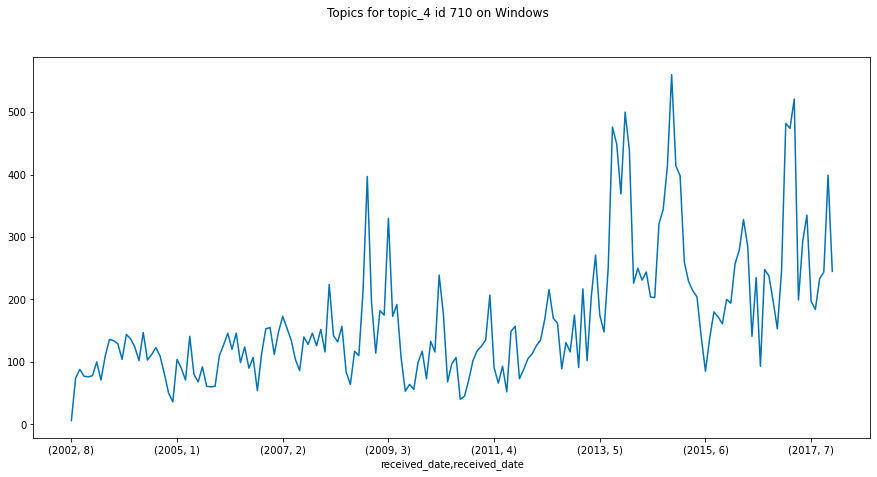

In [108]:
    """
    # Final case A. 
    # Visualize various subareas to make a point
    ID 3374 = Pori lvl 3
    ID 6118 Pyhäjärvi lvl 3
    ID 3372 Helsinki lvl 3
    
    mistä löytyy tsunami?
    ID 6157 Maahanmuutto lvl 2 2015 maahanmuuttoaalto
    ID 4002 Uusivuosi lvl 3
    ID 3456 Euroviisut
    ID 5619 hiihto lvl 3
    ID 3925 ilmailu lvl 2 Jämijärven onnettomuus 20.4.2014
    ID 3704 Perussuomalaiset lvl 4
    
    ID 4334 VHH lvl 4
    ID 3859 Fortum lvl 4
    ID 1448 Pörssiyhtiöt lvl 3
    ID 710 Pörssi ja osakkeet lvl 2
    
    ID 4749 Siitepölyallergia lvl 4
    ID 3410 Olympialaiset lvl 2
    
    ID 3880 Kysy terveydestä lvl 2
    ID 3548 Yleistä terveydestä lvl 2
    ID 4531 Valuutat vl 2
    ID 5530 BED lvl 4

    # by comments (size)
    # get topicNames instead of IDs
    """
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    topic_filter = "topic_2"
    topicfilterid = 710
    topiclevel = "topic_3"

    a = series.loc[series[topic_filter] == topicfilterid, ["received_date", topiclevel, "wordcount"]]
    
    b = a.groupby([a["received_date"].dt.year,a["received_date"].dt.month]).size()
    #b = a.groupby([a["received_date"].dt.year,a["received_date"].dt.week]).size()
    #b = a.groupby([a["received_date"].dt.year,a["received_date"].dt.dayofyear]).size()
    #b = a.groupby([a["received_date"].dt.year]).size()
    c = a.groupby([a["received_date"].dt.month,a[topiclevel]]).size()
    
    figb, axes = plt.subplots(1, 1, sharey=True, figsize=image_dims) # ensure y is shared
    figb.suptitle("Topics for "+topicfilter+" id "+str(topicfilterid)+" on Windows")
   
    b.plot(ax=axes, legend=False)
    c.unstack().plot(ax=axes[1], legend=True)
    
    axes.set_title("Full "+topicfilter+" id "+str(topicfilterid))
    #axes[1].set_title(topicfilter+" area "+str(topicfilterid)+" subtopics by year")
    
    #series = jemma # palautetaan iso data takaisin series-muuttujaan
    
    figb.savefig("figure-b-porssi-"+topicfilter+"-"+str(topicfilterid)+".png")
    
    del a, b

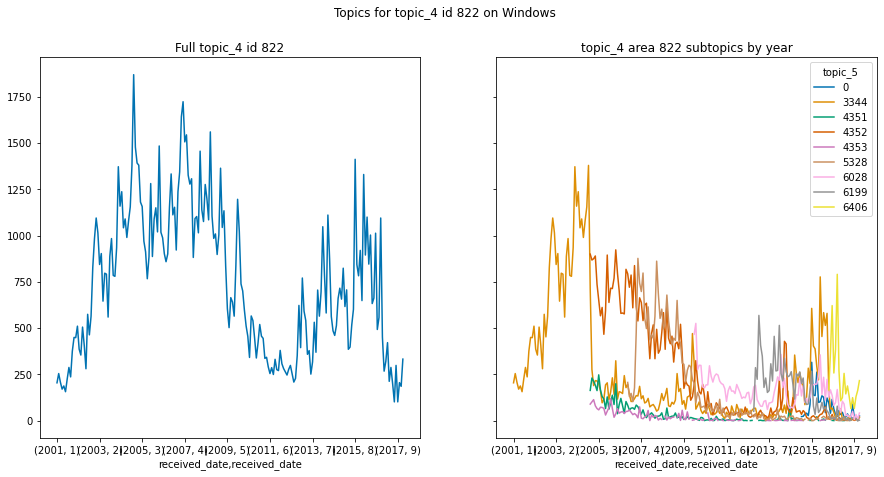

In [107]:
    """
    # Exploratory case b. 
    # Visualize Windows subarea to show how larger waves are created from smaller ones
    # how discussion waves get aggregated into one large wave

    # by comments (size)
    # get topicNames instead of IDs
    """
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.
    
    topic_filter = "topic_4"
    topicfilterid = 822
    topiclevel = "topic_5"

    a = series.loc[series[topic_filter] == topicfilterid, ["received_date", topiclevel, "wordcount"]]
    
    #b = a.groupby([a["received_date"].dt.year]).size()
    b = a.groupby([a["received_date"].dt.year,a["received_date"].dt.month]).size()
    c = a.groupby([a["received_date"].dt.year,a["received_date"].dt.month,a[topiclevel]]).size()
    
    figb, axes = plt.subplots(1, 2, sharey=True, figsize=image_dims) # ensure y is shared
    figb.suptitle("Topics for "+topicfilter+" id "+str(topicfilterid)+" on Windows")
   
    b.plot(ax=axes[0], legend=False)
    c.unstack().plot(ax=axes[1], legend=True)
    
    axes[0].set_title("Full "+topicfilter+" id "+str(topicfilterid))
    axes[1].set_title(topicfilter+" area "+str(topicfilterid)+" subtopics by year")
    
    #series = jemma # palautetaan iso data takaisin series-muuttujaan
    
    figb.savefig("figure-b-"+topicfilter+"-"+str(topicfilterid)+".png")
    
    del a, b

ValueError: zero-size array to reduction operation fmin which has no identity

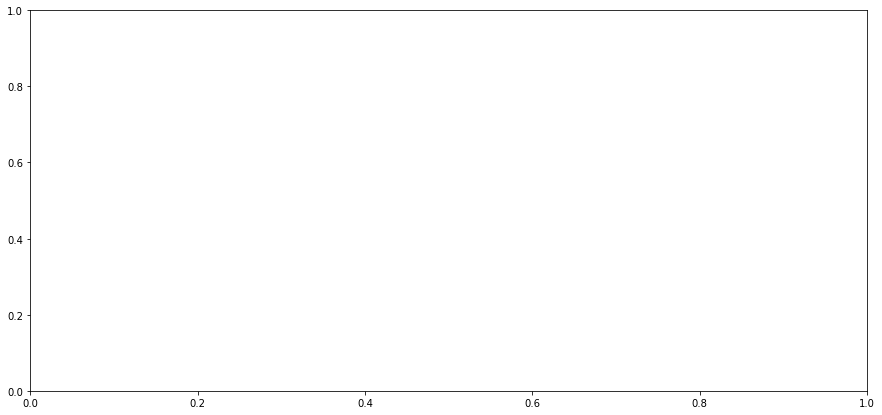

In [15]:
    """
    # Exploratory case c. HEATMAP
    # case Pollen subarea topic_4, id 4749
    # to highlight discussion seasonality
    # by comments (size)
    """

    topic_filter="topic_4"
    topicfilterid="4749" #siitepölyallergia id 4749, level 4

    a = series.loc[series[topic_filter] == topicfilterid, ["received_date", "wordcount"]]
    
    b = a.groupby([a["received_date"].dt.year,a["received_date"].dt.month]).size().astype(float).unstack(level=0)
    
    # total comments reveals the golden age of the forum/each subtopic. Eg pollen peaks in May almost every year
    figc, ax = plt.subplots(figsize=image_dims)
    
    ax = sns.heatmap(b, cmap="icefire")
    ax.set_xlabel("year") 
    ax.set_ylabel("month")
    ax.set_title("Pollen and allergies "+topic_filter+" id "+str(topicfilterid)+" comments, by year and month") # remember to change the labels!!
    
    figc.savefig("figure-c-"+topic_filter+"-"+str(topicfilterid)+".png")
    
    del a, b

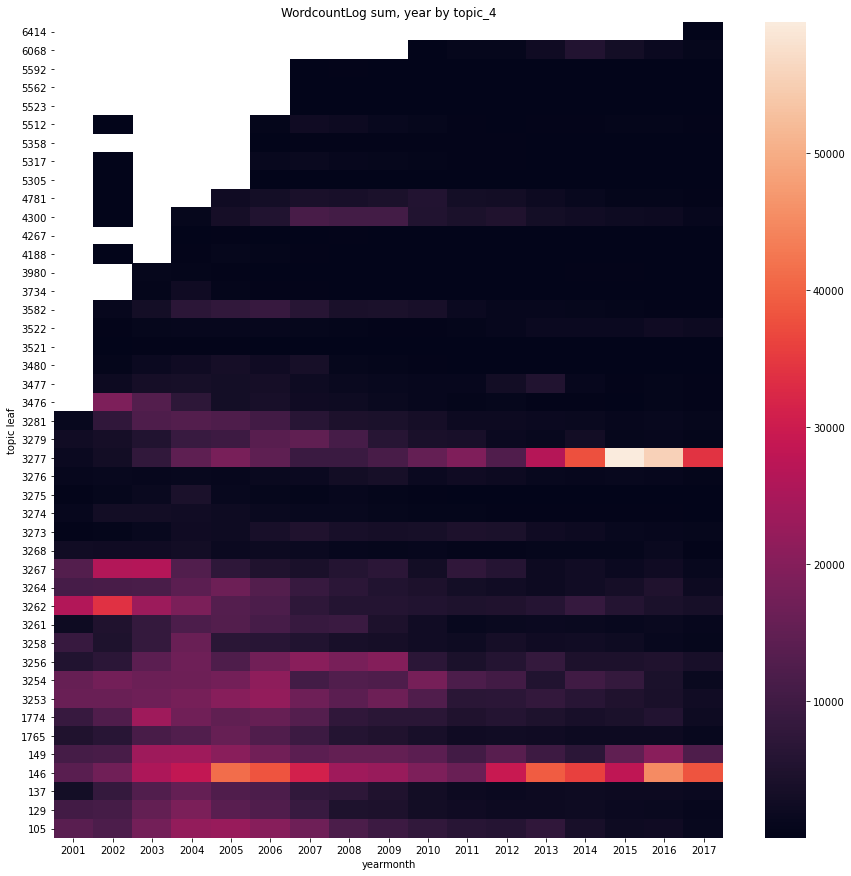

In [17]:
    """
    # Exploratory case d. HEATMAP
    # Visualize different active subareas to show how waves follow each other
    """
    
    # 12c: wordcounts per topicarea level (data subset) prepare a: comments, b: threads
    # idea is to present how activity has moved in different topic areas over years
    # some topic areas have been more active during some years, some topic areas during others
    # using this to pick largest discussion areas
    ## LOOK AT MONTHLY SEASONALITY WITHIN THESE ONLY, AND WITHIN THE INACTIVE ONES ONLY

    ## case 1a: yhteiskunta-uskonnot
    # lvl 1: yhteiskunta 21
    # level2: uskonnot ja uskomukset id 36  
    # level3; kristinusko id 2366 
    # level 4; lestadiolaisuus id 926; helluntailaisuus id 3899; luterilaisuus 3782
    
    ## case 1b: yhteiskunta-politiikka
    # lvl 1: yhteiskunta 21
    # level2: politiikka 17  
    # level3; puolueet 6062 
    # level 4; kepu 3541; anarkismi 3542; persut 3704; RKP 3565; SKP 4015
    
    ## case 1c: yhteiskunta-yleinen
    # lvl 1: yhteiskunta 21
    # level 2: *maailman menoa 3353

    ## case 2: paikkakunnat
    # level 1; paikkakunnat id 22 
    # lvl2: Pohjois-Pohjanmaa 2528; Pohjois-Karjala 2527; Lappi 2524; Etelä-Pohjanmaa 2516
    # en mene syvemmälle
    
    ## case 3: ihmissuhteet
    # level 1: suhteet  id 38
    # lvl 2: *miehen logiikka 3619; *sinkut 3404; tunteet 2392
    # lvl 3: ihastuminen 3620; järki ja tunteet 5117; ikävä 5307
    
    ## case 4: autot
    # level 1: Ajoneuvot ja liikenne id 2
    # lvl 2: autot 6254; *kaksipyöräiset 6; *liikenne 10
    # lvl 3: automerkit 1109; *yleistä autoilusta 3272; *autoverot ja vakuutukset 3558; *auton ostaminen 4255
    # lvl 4: Alfa Romeo 3476 (Kari Hotakainen Finlandia 2002, Klassikko 1997); Skoda 3277; Saab 3267; MB 3262; Audi 3256; Volvo 1774; Volkswagen 149; Toyota 146

    ## case 5: viihde
    # level 1: viihde ja kulttuuri  id 6052
    # lvl 2: julkkikset 34, *musiikki 31, *kirjallisuus 20, tv ja radio 14
    # lvl 3: tv-sarjat 845; *julkkisjuorut 3359
    # lvl 4: big brother 829; idols 3994
    
    ## case 6: terveys (for own interst)
    # lvl 1: id 4
    # lvl 2: terveyden hoito 6279; sairaudet 6271; painonhallinta 6267; mielenterveys 2795; päihteet 2123
    
    ## case 7. yhteiskunta - maahanmuutto (varsin pientä)
    # lvl 1: 21
    # lvl 2: maahanmuutto 6157 - noussut 2016; NATO 3424; feminismi 3576
    
    ## case 8. talous (for own interst)
    # lvl1: talous 33
    # lvl2: verkostomarkkinointi 4241; maatila ja metsä 58; pankit 4988; lainat ja velka 3662; yrittäjyys 3645

    ## case 8. tiede ja teknologia (for own interst)
    # lvl1: 6051
    # lvl2: tietotekniikka 15; tiede 54; internet 6264; kodintekniikka 6257

    topic_filter = "topic_3"
    topic_filterid = 1109 
    topiclevel="topic_4"
    
    a = series.loc[((series[topiclevel] !=0) & (series[topic_filter]==topic_filterid)), ["received_date", topiclevel, "wordcountLog"]]

    #requires adding astype(float) at the end for some reason
    b = a.pivot_table(values="wordcountLog",index=topiclevel,columns=a["received_date"].dt.year,aggfunc=np.sum).astype(float)
    b.sort_index(level=0, ascending=False, inplace=True)
    
    figd, ax = plt.subplots(figsize=image_dims_large)
    
    ax = sns.heatmap(b, cmap="rocket")

    ax.set_xlabel("yearmonth") 
    ax.set_ylabel("topic leaf")
    ax.set_title("WordcountLog sum, year by "+topiclevel)
    
    figd.savefig("figure-d-"+topic_filter+"-"+str(topic_filterid)+".png")

# Next question: 
- What other patterns could there be?
- Do different patterns combine differentially in different topic areas? Why would that be?

In [ ]:
    # 8: for comments vs wordcounts per yearmonth
    # different topic areas vary in word use
    # fewer comments per timeframe can be correlated to both wordy and less wordy comments
    # wordcount is mean, not sum. could be something else too
    
    # this takes ages, so don't do this anymore before changing something. The pic is always the same.

    topiclevel1="topic_1"
    topiclevel2="topic_2" # topic_leaves works slightly better; for all levels of leaves, ie including also those only under topic_1

    a = series.loc[series[topiclevel1] !=0, ["received_date", topiclevel1, topiclevel2, "wordcount"]]
    b = a.loc[series[topiclevel2] !=0, ["received_date", topiclevel1, topiclevel2, "wordcount"]]
    
    b[topiclevel1] = b[topiclevel1].astype("category") # recast this for visualizations, not before
    b[topiclevel2] = b[topiclevel2].astype("category")
   
    c=b.groupby([b["received_date"].dt.year,b["received_date"].dt.month, b[topiclevel1]]).agg({topiclevel2:"size","wordcount":"mean"})

    cy = c["wordcount"]
    cx = c[topiclevel2]
        
    fig8, ax = plt.subplots(figsize=image_dims)
    
    sns.scatterplot(x=cx, y=cy, data = c, hue=topiclevel1, style=topiclevel1)
    
    plt.xlabel(topiclevel2+" comments")
    plt.ylabel("wordcount mean")
    ax.set(xscale="log")
    ax.set(yscale="log")
    
    fig8.savefig("figure-8-"+shortFileName+"-"+topiclevel1+"-"+topiclevel2+".png")
    
    del a, b, c, cx, cy

## Test machine learning - preprocessing

- Split to train and test sets

In [ ]:
#series.describe()

print(series.head)

In [ ]:
msk = np.random.rand(len(series)) < trainingSetSize
subSeries = series[["wordcount","wordcountLog","topic_leaves","received_date", "comment_id"]] # select only certain variables

train = subSeries[msk]
test = subSeries[~msk]

# ML 1: linear regression with train set

# a. are later comments more or less wordy? comment_id against wordcount:
# Coefficients:  [[-2.29396935e-07]]
# Intercept:  [58.20597541]
# Mean absolute error: 40.75
# Residual sum of squares (MSE): 5603.40
# R2-score: 0.01

# b. changing wordcount to wordcountLog:
# Coefficients:  [[-2.36343726e-09]]
# Intercept:  [1.51276609]
# Mean absolute error: 0.39
# Residual sum of squares (MSE): 0.24
# R2-score: 0.02
# if anything, the relationship is not linear (this we knew)

# c. how about topic leaves ie. the path
# change categorical var to dummy numeric
# would it be better to have the length of path? ie how low in hierarchy the topicarea is. 
# no theoretical reason for this and the suspicion is anyway that level 3 is most represented (normal distr)

regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[["comment_id"]])
train_y = np.asanyarray(train[["wordcountLog"]])
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

plt.scatter(train.comment_id, train.wordcountLog,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Topic_leaves")
plt.ylabel("WordcountLog")

# Evaluate regression
# Mean Absolute Error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
# Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean Absolute Error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
# Root Mean Squared Error (RMSE).
# R-squared is not an error, but rather a popular metric to measure the performance of your regression model. It represents how close the data points are to the fitted regression line. The higher the R-squared value, the better the model fits your data. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

test_x = np.asanyarray(test[["comment_id"]])
test_y = np.asanyarray(test[["wordcountLog"]])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

In [ ]:
# ML 2: multiple linear regression
# note! all relationships between variables should be linear
# this condition is oftentimes hard to fulfill
msk = np.random.rand(len(series)) < trainingSetSize
subSeries = series[["wordcount","wordcountLog","topic_leaves","received_date", "comment_id"]] 
# select only certain variables
# note, for monthly analysis, sums of new comments and new threads give a new table and a few new variables

train = subSeries[msk]
test = subSeries[~msk]

regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit (x, y)

# The coefficients
print ('Coefficients: ', regr.coef_)

# prediction
y_hat= regr.predict(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
x = np.asanyarray(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asanyarray(test[['CO2EMISSIONS']])

print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

In [ ]:
# ML 3: polynomial linear regression
msk = np.random.rand(len(series)) < trainingSetSize
subSeries = series[["wordcount","wordcountLog","topic_leaves","received_date", "comment_id"]] 
# select only certain variables
# note, for monthly analysis, sums of new comments and new threads give a new table and a few new variables

train = subSeries[msk]
test = subSeries[~msk]

scaler = preprocessing.StandardScaler()

train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])

# A. do polyfit
poly = PolynomialFeatures(degree=3)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

# B. transformation and use lin reg
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)

# OR, do A-B in one go in a pipeline
polyreg_scaled = make.pipeline(PolynomialFeatures(degree=3), scaler, LinearRegression())
train_y_ = polyreg_scaled.fit(train_x, train_y)

# print coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

# plot
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
XX = np.arange(0.0, 10.0, 0.1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)+ clf.coef_[0][3]*np.power(XX, 3)
plt.plot(XX, yy, '-r' )
plt.xlabel("Engine size")
plt.ylabel("Emission")

# evaluate

test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_ ) )

In [ ]:
# ML 4: K-NN K nearest neighbors classification scheme

# To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array

k = 4

X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']] .values  #.astype(float)

# Data Standardization gives the data zero mean and unit variance, 
# it is good practice, especially for algorithms such as KNN 
# which is based on the distance of data points:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=testSize, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Train Model and Predict. Typically K = 4 works best so can start with that
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

yhat = neigh.predict(X_test)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

# or: predict for many k:s and select the best
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

# In multilabel classification, accuracy classification score is a function that 
# computes subset accuracy. This function is equal to the jaccard_score function. 
# Essentially, it calculates how closely the actual labels and predicted labels 
# are matched in the test set. Closer to 1 is better.

# plot accuracy variance
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 